## Chapter 2.1 Forward Gravity: Simple example

In [1]:
# These two lines are necessary only if gempy is not installed
import sys, os
sys.path.append("../../..")

# Importing gempy
import gempy as gp

# Embedding matplotlib figures into the notebooks
%matplotlib inline


# Aux imports
import numpy as np
import pandas as pn
import matplotlib.pyplot as plt
import theano
import qgrid

In [2]:
geo_model = gp.load_model('Greenstone', path= '../../data/gempy_models')

Active grids: ['regular']


In [3]:
geo_model.series

,order_series,BottomRelation,isActive
EarlyGranite_Series,1,Erosion,True
BIF_Series,2,Erosion,True
SimpleMafic_Series,3,Erosion,True
Basement,4,Erosion,False


In [4]:
geo_model.surfaces

,surface,series,order_surfaces,isActive,color,id,value_0
3,EarlyGranite,EarlyGranite_Series,1,True,#728f02,1,2.61
0,SimpleMafic2,BIF_Series,1,True,#015482,2,2.92
1,SimpleBIF,BIF_Series,2,True,#9f0052,3,3.1
2,SimpleMafic1,SimpleMafic_Series,1,True,#ffbe00,4,2.92
4,basement,Basement,1,True,#443988,5,2.61


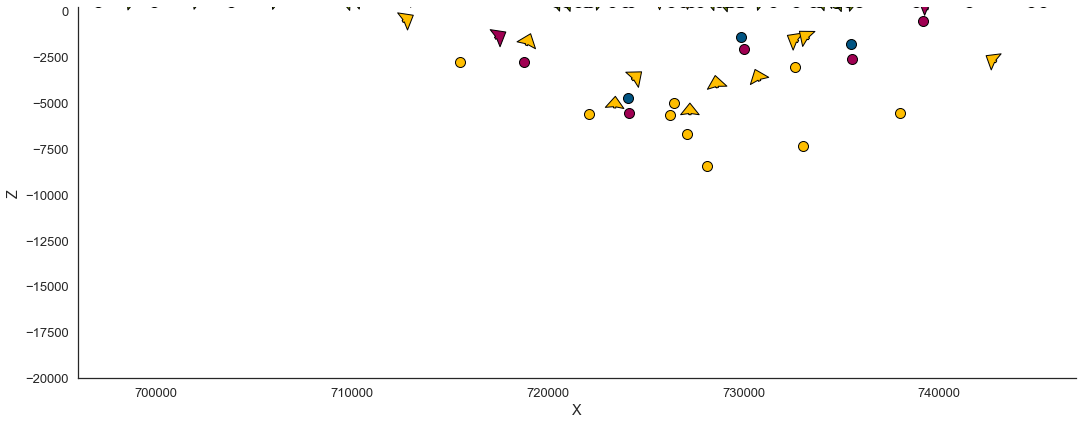

In [5]:
gp.plot.plot_data(geo_model)

In [6]:
# Compute normal model:
# gp.set_interpolation_data(geo_model,
#                           compile_theano=True,
#                           theano_optimizer='fast_compile',
#                           verbose=[])
# gp.compute_model(geo_model)

### Creating grid

First we need to define the location of the devices. For this example we can make a map:

In [7]:
grav_res = 20
X = np.linspace(7.050000e+05, 747000, grav_res)
Y = np.linspace(6863000, 6925000, grav_res)
Z= 300
xyz= np.meshgrid(X, Y, Z)
xy_ravel = np.vstack(list(map(np.ravel, xyz))).T
xy_ravel

array([[7.05000000e+05, 6.86300000e+06, 3.00000000e+02],
       [7.07210526e+05, 6.86300000e+06, 3.00000000e+02],
       [7.09421053e+05, 6.86300000e+06, 3.00000000e+02],
       ...,
       [7.42578947e+05, 6.92500000e+06, 3.00000000e+02],
       [7.44789474e+05, 6.92500000e+06, 3.00000000e+02],
       [7.47000000e+05, 6.92500000e+06, 3.00000000e+02]])

We can see the location of the devices relative to the model data:

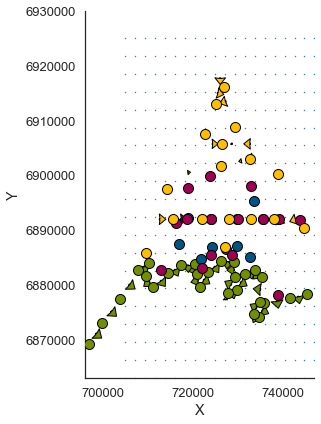

In [8]:
import matplotlib.pyplot as plt
gp.plot.plot_data(geo_model, direction='z')
plt.scatter(xy_ravel[:,0], xy_ravel[:, 1], s=1)

Now we need to create the grid centered on the devices (see: https://github.com/cgre-aachen/gempy/blob/master/notebooks/tutorials/ch1-3-Grids.ipynb)

In [9]:
geo_model.set_centered_grid(xy_ravel,  resolution = [10, 10, 15], radius=5000)

Active grids: ['regular' 'centered']


Grid Object. Values: 
array([[ 6.96510000e+05,  6.86367000e+06, -1.97980000e+04],
       [ 6.96510000e+05,  6.86367000e+06, -1.93940000e+04],
       [ 6.96510000e+05,  6.86367000e+06, -1.89900000e+04],
       ...,
       [ 7.52000000e+05,  6.93000000e+06, -3.10768481e+03],
       [ 7.52000000e+05,  6.93000000e+06, -4.31811404e+03],
       [ 7.52000000e+05,  6.93000000e+06, -6.00000000e+03]])

In [10]:
geo_model.grid.centered_grid.kernel_centers

array([[-5000.        , -5000.        ,  -300.        ],
       [-5000.        , -5000.        ,  -360.        ],
       [-5000.        , -5000.        ,  -383.36972966],
       ...,
       [ 5000.        ,  5000.        , -3407.68480754],
       [ 5000.        ,  5000.        , -4618.11403801],
       [ 5000.        ,  5000.        , -6300.        ]])

Now we need to compute the component tz (see https://github.com/cgre-achen/gempy/blob/master/notebooks/tutorials/ch2-2-Cell_selection.ipynb)

In [11]:
from gempy.assets.geophysics import GravityPreprocessing

In [12]:
g = GravityPreprocessing(geo_model.grid.centered_grid)

In [13]:
tz = g.set_tz_kernel()

In [14]:
tz

array([-0.04358897, -0.03537441, -0.02602098, ..., -6.04561025,
       -8.88406645, -9.82814234])

### Compiling the gravity graph

If geo_model has already a centered grid, the calculation of tz happens automatically. Alternatively you pass tz to `set_gravity interpolator`. This theano graph will return gravity instead the lithologies. In addition we need either to pass the density block (see below). Or the position of density on the surface(in the future the name) to compute the density block at running time.

In [15]:
geo_model.surfaces

,surface,series,order_surfaces,isActive,color,id,value_0
3,EarlyGranite,EarlyGranite_Series,1,True,#728f02,1,2.61
0,SimpleMafic2,BIF_Series,1,True,#015482,2,2.92
1,SimpleBIF,BIF_Series,2,True,#9f0052,3,3.1
2,SimpleMafic1,SimpleMafic_Series,1,True,#ffbe00,4,2.92
4,basement,Basement,1,True,#443988,5,2.61


In this case the densities of each layer are at the loc 1 (0 is the id)

In [16]:
# Old way
#geo_model.set_gravity_interpolator(pos_density=1, verbose=['grid_shape', 'slices'])

# New way
gp.set_interpolator(geo_model, output=['gravity'], pos_density=1,  gradient=False,
                    theano_optimizer='fast_run')  

Compiling theano function...
Level of Optimization:  fast_run
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!


Once we have created a gravity interpolator we can call it from compute model as follows:

In [17]:
sol = gp.compute_model(geo_model, output=['geology'])
grav = sol.fw_gravity

../../../gempy/core/solution.py:266: UserWarning: Attribute error. Using non masked marching cubesmarching_cubes_lewiner() got an unexpected keyword argument 'mask'.
  warnings.warn('Attribute error. Using non masked marching cubes' + str(e)+'.')


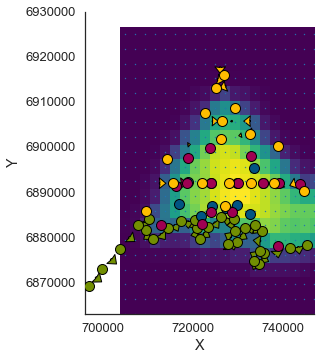

In [18]:
gp.plot.plot_data(geo_model, direction='z', height=7)
plt.scatter(xy_ravel[:,0], xy_ravel[:, 1], s=1)
plt.imshow(sol.fw_gravity.reshape(grav_res, grav_res), extent = (xy_ravel[:,0].min() + (xy_ravel[0, 0] - xy_ravel[1, 0])/2,
                                                       xy_ravel[:,0].max() - (xy_ravel[0, 0] - xy_ravel[1, 0])/2,
                                                       xy_ravel[:,1].min() + (xy_ravel[0, 1] - xy_ravel[30, 1])/2,
                                                       xy_ravel[:,1].max() - (xy_ravel[0, 1] - xy_ravel[30, 1])/2),
           cmap='viridis_r', origin='bottom')

#### Plotting lithologies

If we want to compute the lithologies we will need to create a normal interpolator object as seen in the Chapter 1 of the tutorials  

Now we can plot all together (change the alpha parameter to see the gravity overlying):

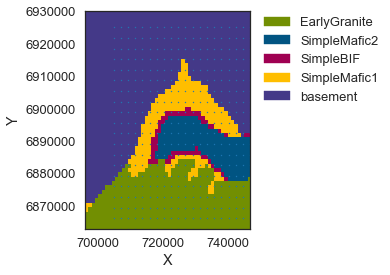

In [19]:
gp.plot.plot_section(geo_model, -1, direction='z')
plt.scatter(xy_ravel[:,0], xy_ravel[:, 1], s=1)
plt.imshow(grav.reshape(grav_res, grav_res), extent = (xy_ravel[:,0].min() + (xy_ravel[0, 0] - xy_ravel[1, 0])/2,
                                                       xy_ravel[:,0].max() - (xy_ravel[0, 0] - xy_ravel[1, 0])/2,
                                                       xy_ravel[:,1].min() + (xy_ravel[0, 1] - xy_ravel[30, 1])/2,
                                                       xy_ravel[:,1].max() - (xy_ravel[0, 1] - xy_ravel[30, 1])/2),
           cmap='viridis_r', origin='bottom', alpha=.0)